# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re

### Read the Data

In [2]:
data = "data_for_student_case.csv" #modify the path here for wherever the data is.
df1 = pd.read_csv(data)

### Transaction Class distributions.

In [3]:
print("Number of total data points = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['simple_journal'] == 'Chargeback'])))
print("Number of valid transactions = " + str(len(df1.loc[df1['simple_journal'] == 'Settled'])))  

Number of total data points = 290382
Number of fradulent transactions = 345
Number of valid transactions = 236691


### A look at the data

In [4]:
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Data Preprocessing

In [5]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    #3-6 is just 3 for cvcresponsecode.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc1 = LabelEncoder()
    enc1.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df1['currencycode'])
    df1['currencycode'] = enc2.transform(df1.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

    enc4 = LabelEncoder()
    enc4.fit(df1['accountcode'])
    df1['accountcode'] = enc4.transform(df1.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)
    
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['date'] = df1['creationdate'].dt.date
        
    enc6 = LabelEncoder()
    enc6.fit(df1['mail_id'])
    df1['mail_id'] = enc6.transform(df1.mail_id)

    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    df1['day_of_week'] = df1['creationdate'].dt.dayofweek

    df1['hour'] = df1['creationdate'].dt.hour
    
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    
    return df1



In [6]:
df1 = preprocess(df1)

In [7]:
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,accountcode,mail_id,ip_id,card_id,date,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,1,2015-11-09 14:26:51,104,2,1998,64800.0,2,104,1,1,...,1,187702,7386,73358,2015-07-01,1,2,23,1435791791,30.446979
1,2,2015-11-09 14:27:38,104,2,2364,44900.0,2,104,1,1,...,1,834,194109,44739,2015-07-02,1,3,4,1435812655,21.096749
2,3,2015-11-23 16:34:16,104,2,1965,149900.0,2,104,1,1,...,1,119287,189655,122802,2015-07-02,1,3,14,1435847428,70.432131
3,4,2015-11-23 16:34:51,104,2,2374,109900.0,2,104,1,1,...,1,173561,8254,70712,2015-07-03,1,4,7,1435910017,51.637700
4,5,2015-11-09 14:26:08,104,6,1301,89900.0,2,104,1,1,...,1,70647,196247,208481,2015-07-08,1,2,18,1436380535,42.240484


Number of unique card ids with fraud=309


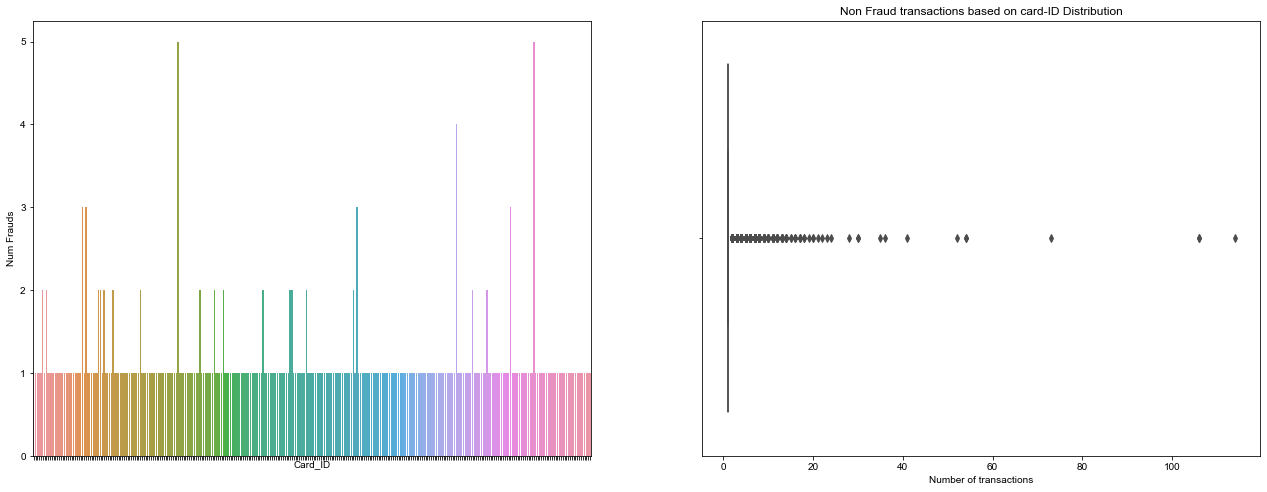

In [8]:
df2 = df1.loc[df1["simple_journal"]==1][['card_id','simple_journal']].groupby(['card_id']).sum()
print("Number of unique card ids with fraud="+str(len(df2.loc[df2['simple_journal'] > 0])))
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df2.index,y=df2['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_xlabel('Card_ID')
for label in ax1.get_xticklabels():
    label.set_visible(False)
df2 = df1.loc[df1["simple_journal"]==0][['card_id','simple_journal']].groupby(['card_id']).count()
sns.set(style="whitegrid")
sns.boxplot(df2.simple_journal.values,ax=ax2)
ax2.set_title("Non Fraud transactions based on card-ID Distribution")
ax2.set_xlabel('Number of transactions')    
plt.show()

Number of unique IP ids with fraud=307


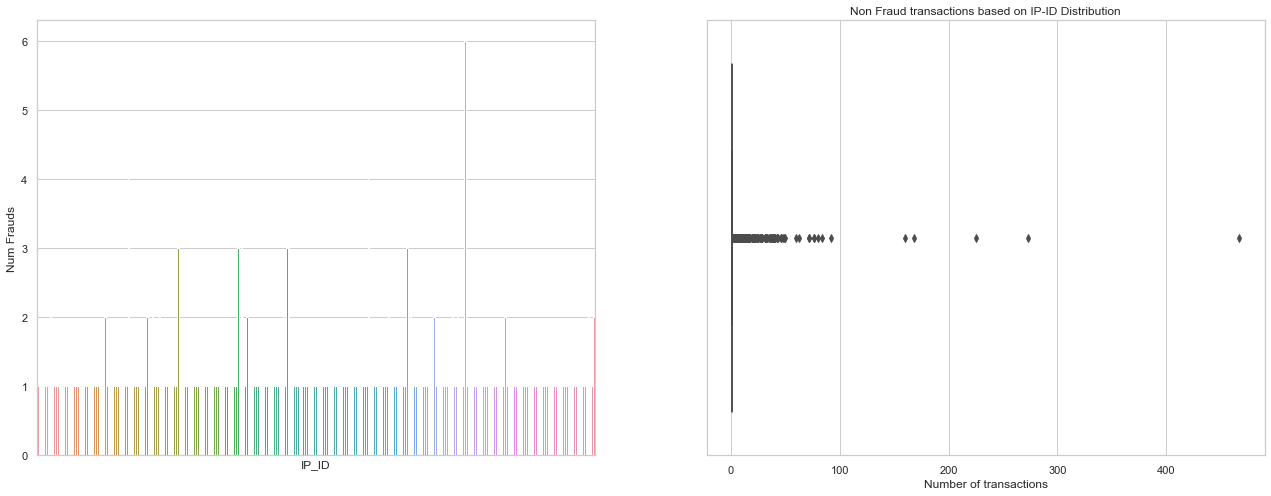

In [9]:
df2 = df1.loc[df1["simple_journal"]==1][['ip_id','simple_journal']].groupby(['ip_id']).sum()
print("Number of unique IP ids with fraud="+str(len(df2.loc[df2['simple_journal'] > 0])))
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df2.index,y=df2['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_xlabel('IP_ID')
for label in ax1.get_xticklabels():
    label.set_visible(False)
df2 = df1.loc[df1["simple_journal"]==0][['ip_id','simple_journal']].groupby(['ip_id']).count()
sns.set(style="whitegrid")
sns.boxplot(df2.simple_journal.values,ax=ax2)
ax2.set_title("Non Fraud transactions based on IP-ID Distribution")
ax2.set_xlabel('Number of transactions')    
plt.show()

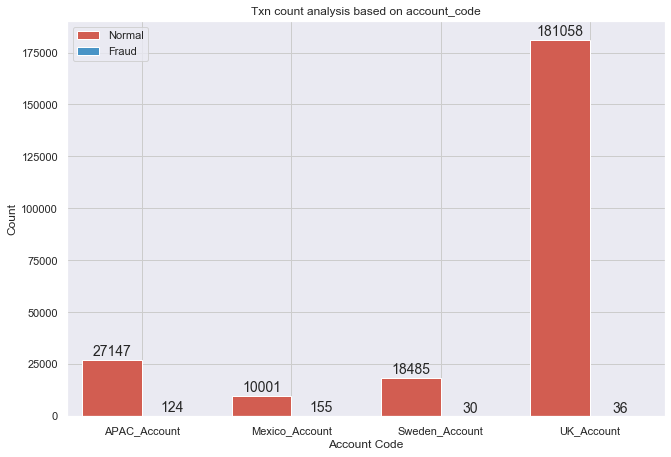

In [10]:
sns.set(rc={'figure.figsize':(10.7,7.27)})
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="accountcode", hue="simple_journal", data=df1, palette=flatui)
ax.set_title('Txn count analysis based on account_code')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Account Code')
ax.set(xticklabels=["APAC_Account","Mexico_Account","Sweden_Account","UK_Account"])
ax.legend(["Normal","Fraud"]) 
max_height = 0


for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height),
            ha="center",size=14)

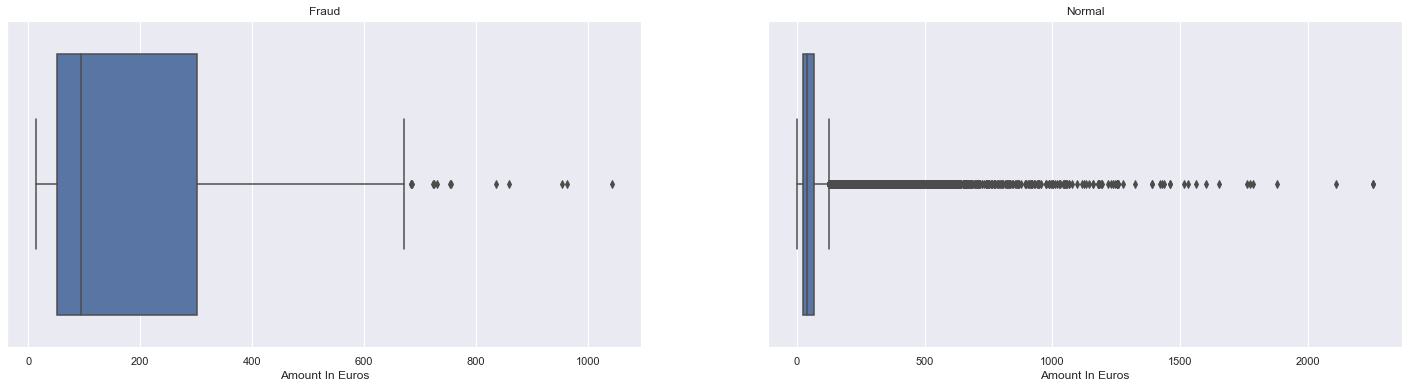

In [11]:
df_f = df1.loc[df1.simple_journal==1]
df_nf = df1.loc[df1.simple_journal==0]
nf_amt=df_nf.amount_eur.values
f_amt=df_f.amount_eur.values 
f, (ax1, ax2) = plt.subplots(1,2,figsize =(25, 6))
sns.boxplot(f_amt,ax=ax1)
ax1.set_title('Fraud')
sns.boxplot(nf_amt,ax=ax2)
ax2.set_title('Normal')
ax2.set_xlabel("Amount In Euros")
ax1.set_xlabel("Amount In Euros")
plt.show()

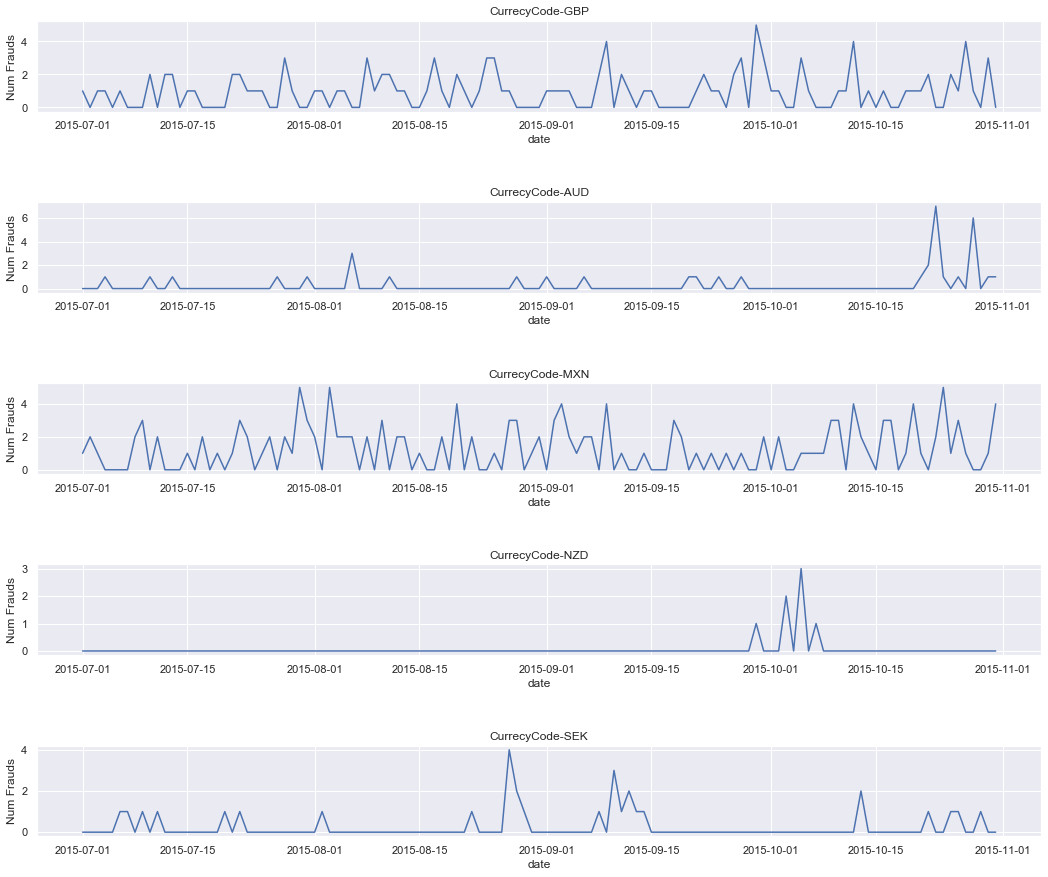

In [12]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['date','simple_journal']].groupby(['date']).sum()
df_AUD = df_AUD[['date','simple_journal']].groupby(['date']).sum()
df_MXN = df_MXN[['date','simple_journal']].groupby(['date']).sum()
df_NZD = df_NZD[['date','simple_journal']].groupby(['date']).sum()
df_SEK = df_SEK[['date','simple_journal']].groupby(['date']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(18, 15))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

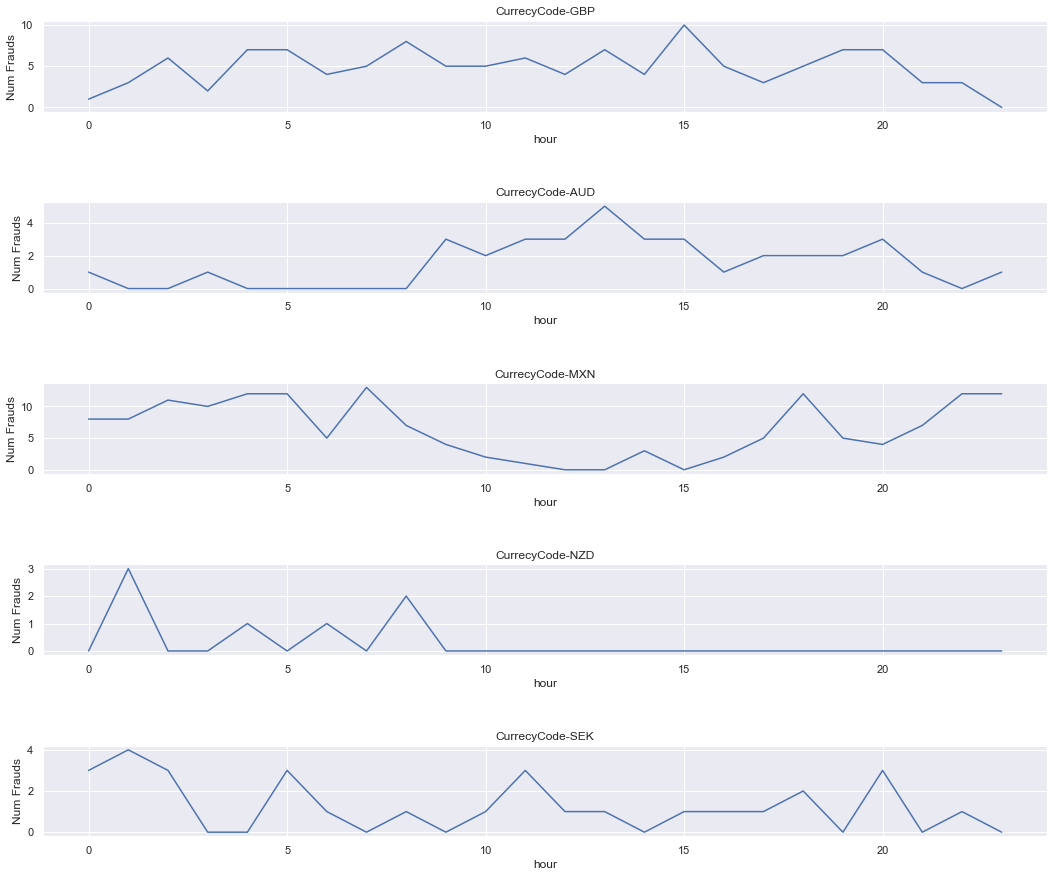

In [13]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['hour','simple_journal']].groupby(['hour']).sum()
df_AUD = df_AUD[['hour','simple_journal']].groupby(['hour']).sum()
df_MXN = df_MXN[['hour','simple_journal']].groupby(['hour']).sum()
df_NZD = df_NZD[['hour','simple_journal']].groupby(['hour']).sum()
df_SEK = df_SEK[['hour','simple_journal']].groupby(['hour']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(18, 15))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

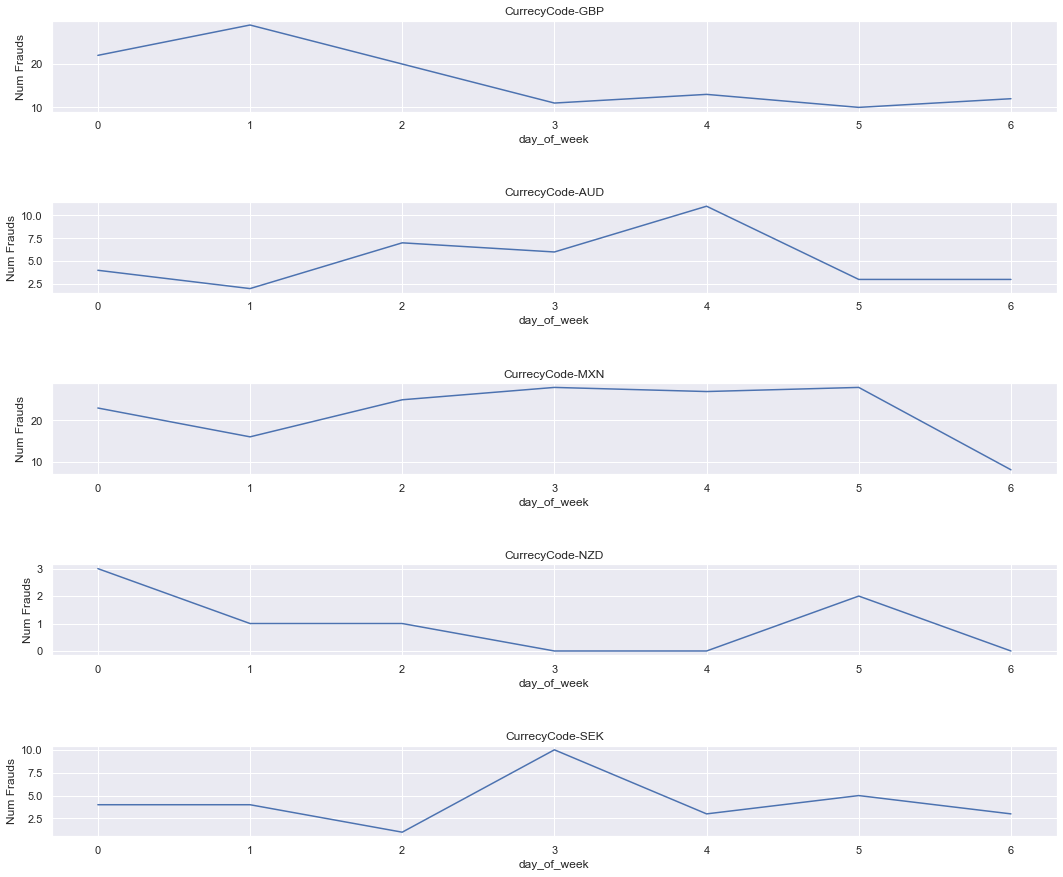

In [14]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['day_of_week','simple_journal']].groupby(['day_of_week']).sum()
df_AUD = df_AUD[['day_of_week','simple_journal']].groupby(['day_of_week']).sum()
df_MXN = df_MXN[['day_of_week','simple_journal']].groupby(['day_of_week']).sum()
df_NZD = df_NZD[['day_of_week','simple_journal']].groupby(['day_of_week']).sum()
df_SEK = df_SEK[['day_of_week','simple_journal']].groupby(['day_of_week']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(18, 15))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

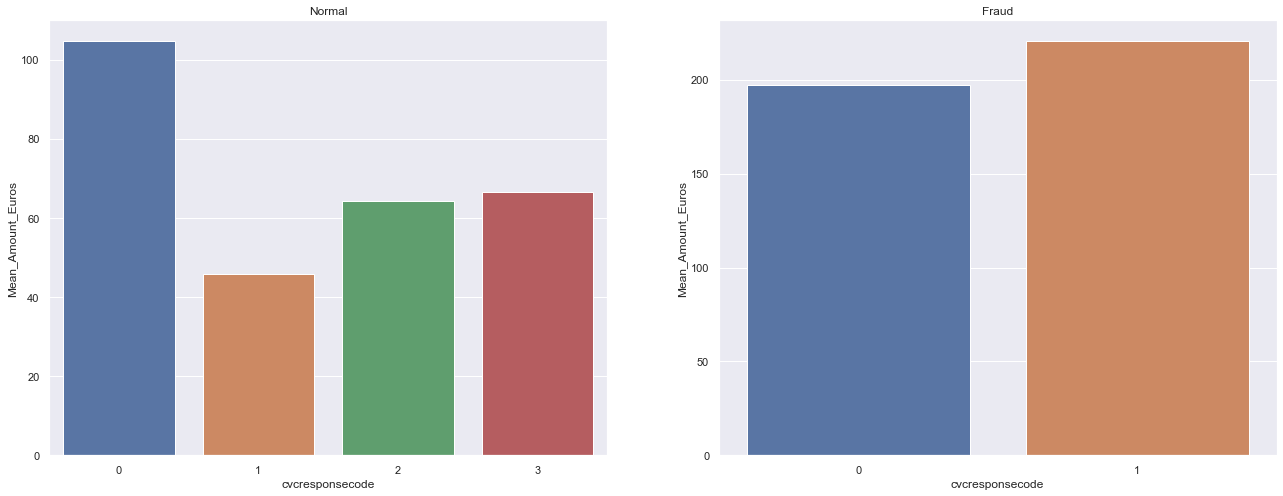

In [15]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[df1["simple_journal"]==0]
df5 = dff[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
df6 = df_nf[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

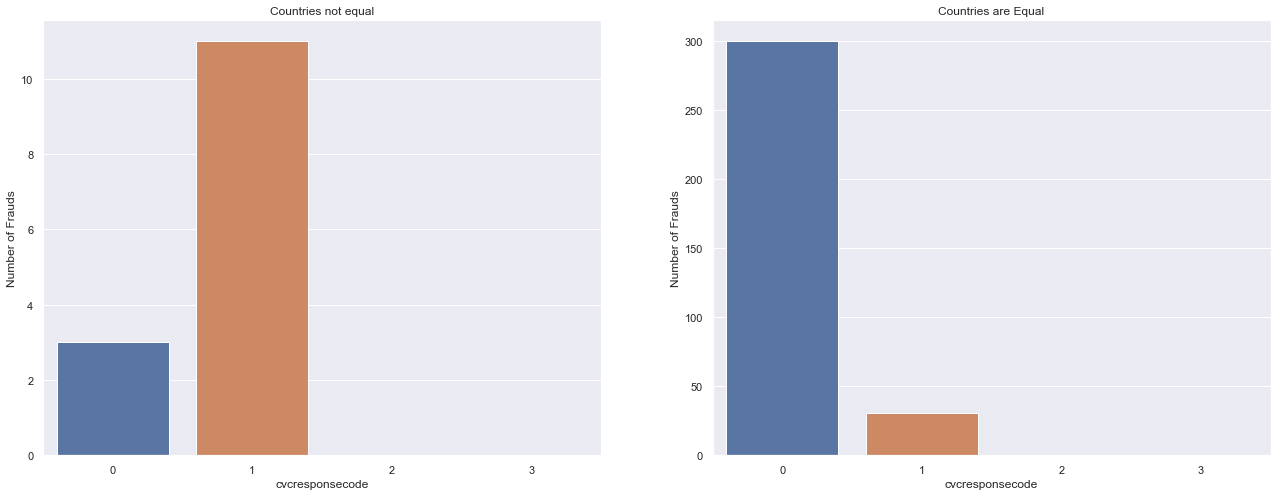

In [16]:
dff= df1.loc[df1["countries_equal"]==1]
df_nf=df1.loc[df1["countries_equal"]==0]
df5 = dff[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
df6 = df_nf[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df5.index,y=df5['simple_journal'],ax=ax2)
ax2.set(ylabel = "Number of Frauds")
ax2.set_title("Countries are Equal")
sns.barplot(x=df6.index,y=df6['simple_journal'],ax=ax1)
ax1.set(ylabel = "Number of Frauds")
ax1.set_title("Countries not equal")
plt.show()

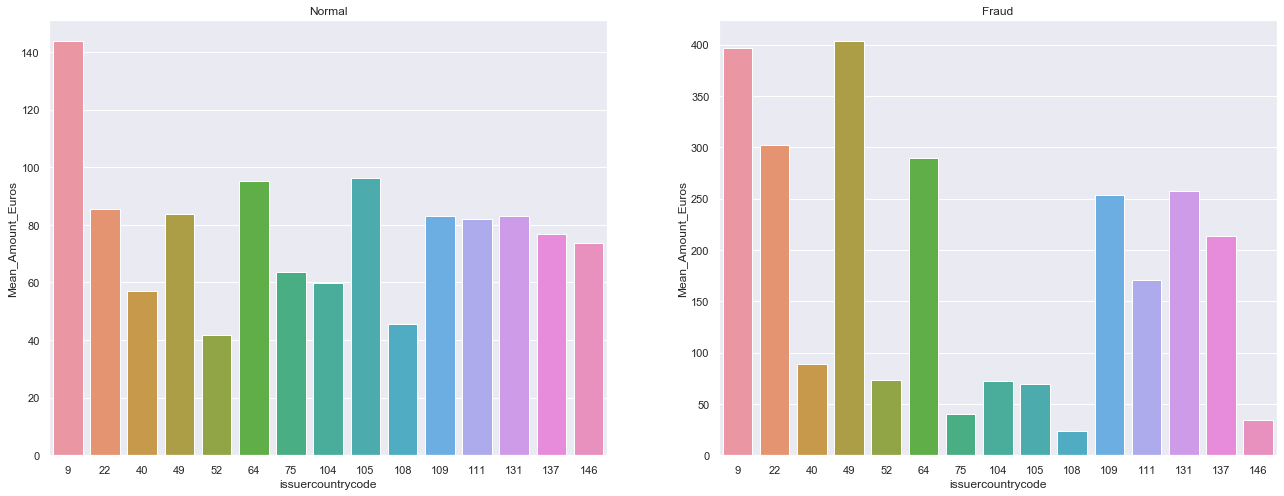

In [17]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[(df1["simple_journal"]==0) & (df1["issuercountrycode"].isin([9,22,40,49,52,64,75,104,105,108,109,111,131,137,146]))]
df5 = dff[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
df6 = df_nf[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

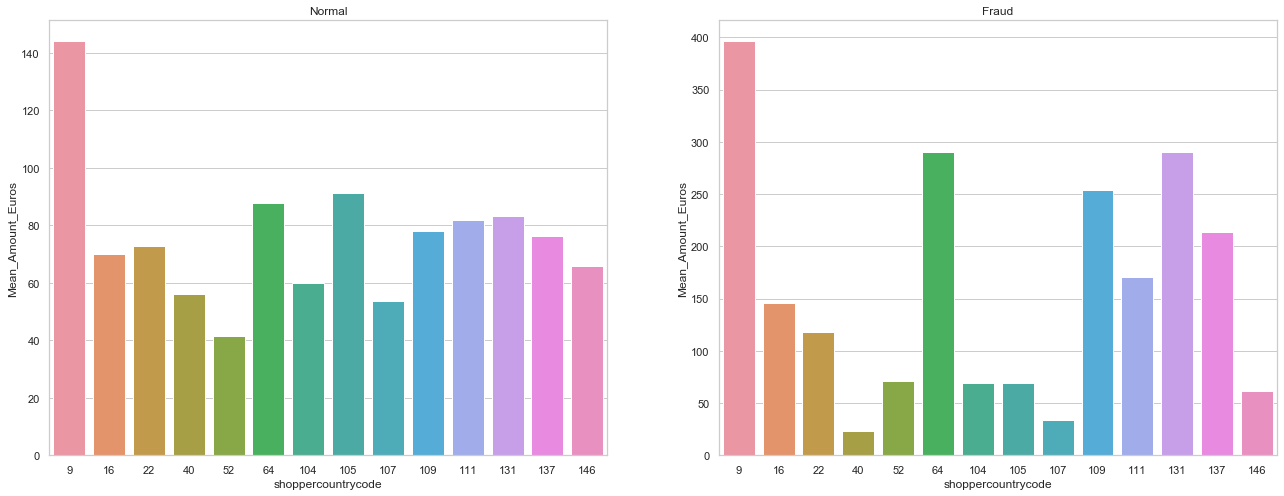

In [21]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[(df1["simple_journal"]==0) & (df1["shoppercountrycode"].isin([9,16,22,40,52,64,104,105,107,109,111,131,137,146]))]
df5 = dff[['shoppercountrycode','amount_eur']].groupby(['shoppercountrycode']).mean()
df6 = df_nf[['shoppercountrycode','amount_eur']].groupby(['shoppercountrycode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

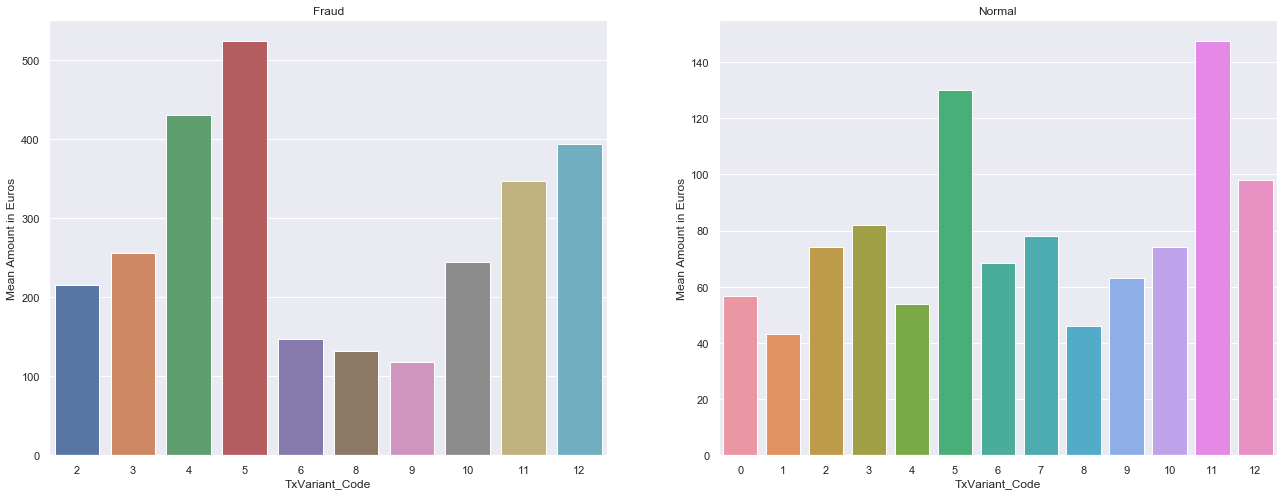

In [18]:
df2 = df1.loc[df1["simple_journal"]==1][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(22, 8))
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean Amount in Euros")
ax1.set_xlabel('TxVariant_Code')
ax1.set_title("Fraud")
df2 = df1.loc[df1["simple_journal"]==0][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
sns.set(style="whitegrid")
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean Amount in Euros")
ax2.set_xlabel('TxVariant_Code')
ax2.set_title("Normal")
plt.show()

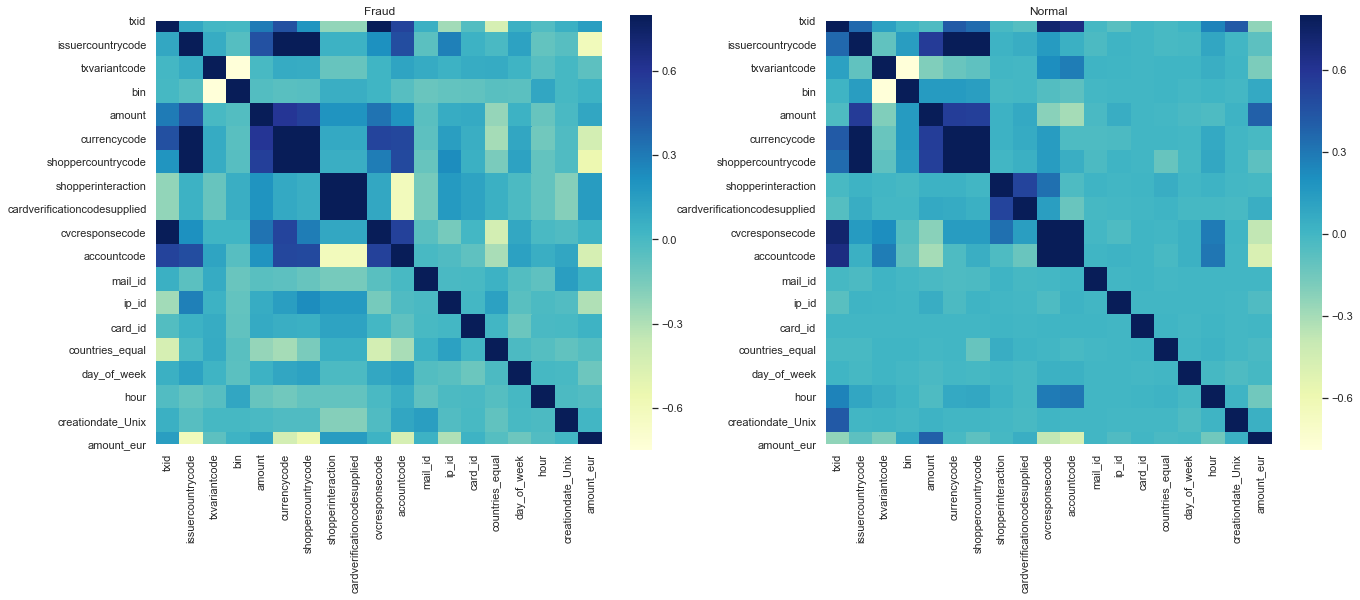

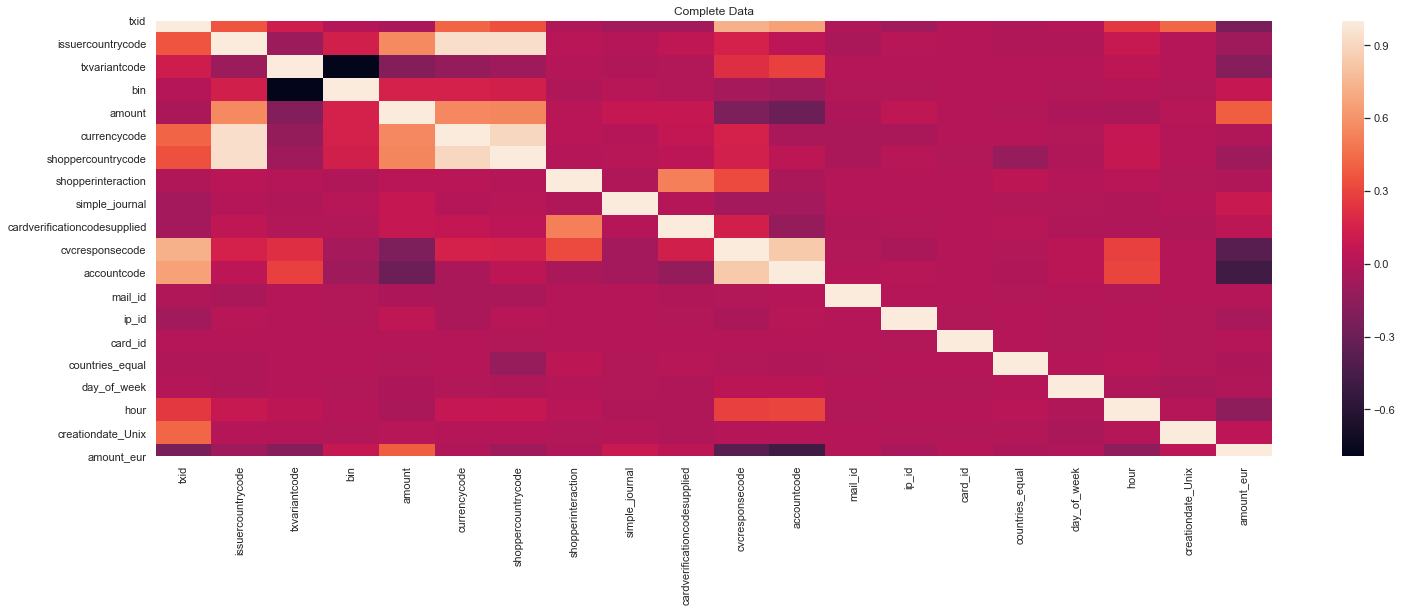

In [19]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df1.query('simple_journal==1').drop('simple_journal',1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df1.query('simple_journal==0').drop('simple_journal',1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1,figsize =(25, 8))
sns.heatmap(df1.corr())
ax1.set_title('Complete Data')
plt.show()
